## multivariate time series analysis using LSTM

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#The data in ma_lga_12345.csv has been resampled to quartely intervals with a median aggregator outside of this notebook
#We will load it and visualise it first
df=pd.read_csv('ma_lga_12345.csv')
df=df[df.type=='house'] #Let's limit the scope of this problem to houses only
df['saledate'] = pd.to_datetime(df['saledate'],infer_datetime_format=True)
df.tail()


,saledate,price,type,bedrooms
195,2018-09-30,1007114,house,5
196,2018-12-31,1002323,house,5
197,2019-03-31,998136,house,5
198,2019-06-30,995363,house,5
199,2019-09-30,970268,house,5


In [3]:
df.shape

(200, 4)

In [4]:
#Pivot the data so we can feed it into the model
df=df.pivot(index='saledate', columns='bedrooms', values='price').interpolate(method='linear', limit_direction='both')
df.tail()


bedrooms,2,3,4,5
saledate,,,,
2018-09-30,504318.0,624602.0,830727.0,1007114.0
2018-12-31,506001.0,626608.0,820924.0,1002323.0
2019-03-31,496133.0,628423.0,811121.0,998136.0
2019-06-30,500158.0,630814.0,803925.0,995363.0
2019-09-30,510712.0,631875.0,791446.0,970268.0


<AxesSubplot:xlabel='saledate'>

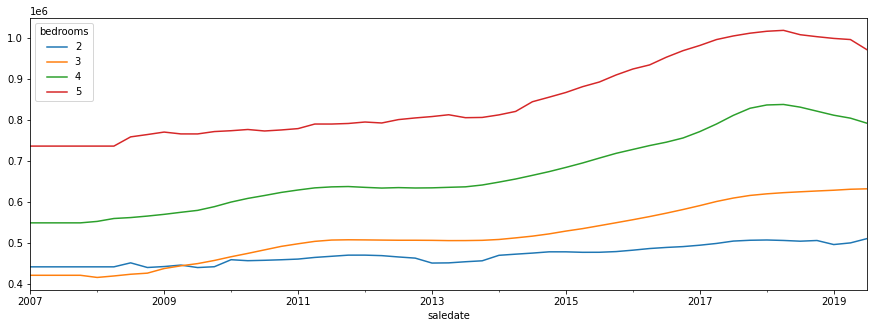

In [5]:
#Plot the data
%matplotlib inline 
df.plot(figsize=(15,5))
#It is evident that 2 bedroom curve before 2009 is not an accurate representation of the actual median price.
#It is not possible for a 2 bedroom median price to be above that of 3 bedroom median price.
#This is due to low number of sales in that timeframe, which skews the calculated median price.

<AxesSubplot:xlabel='saledate'>

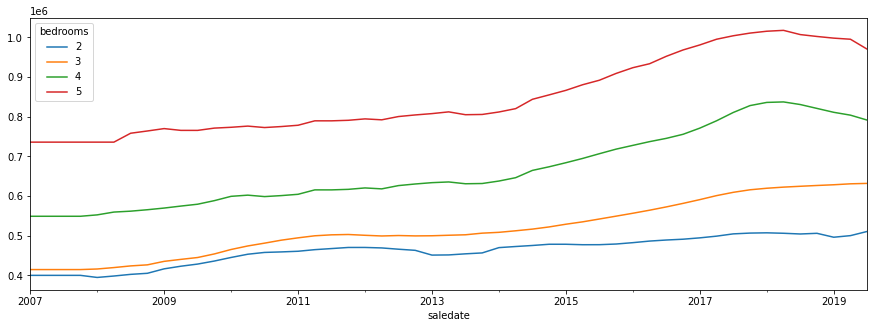

In [6]:
# Let's see what we can do to correct the overlapping lines for 2 and 3 br data
def separate_series(df):
    columns = list(df) 
    for col in columns: 
        if col== columns[-1]:
            break
        #Calculate average difference between 2 and 3 bedrooms for the recent  1/3 of the dataframe
        diff_mean= (df[col+1][:-int(len(df)/3)]-df[col][:-int(len(df)/3)]).mean()
        #Where 2 br price is higher than that of 3 br, replace it with 3 br price minus the diff
        #do_they_intersect = False if df[col].loc[df[col] >= df[col+1], ].empty else True
        #if do_they_intersect:
        df.loc[df[col] > df[col+1]-diff_mean, col] = df[col+1]-diff_mean
    return df
df=separate_series(df)
df.plot(figsize=(15,5))

In [7]:
df.head(15)

bedrooms,2,3,4,5
saledate,,,,
2007-03-31,399989.617647,414576.705882,548969.000000,735904.0
2007-06-30,399989.617647,414576.705882,548969.000000,735904.0
2007-09-30,399989.617647,414576.705882,548969.000000,735904.0
2007-12-31,399989.617647,414576.705882,548969.000000,735904.0
2008-03-31,394729.617647,416031.000000,552484.000000,735904.0
2008-06-30,398326.617647,419628.000000,559580.000000,735904.0
2008-09-30,402509.617647,423811.000000,561852.000000,758340.0
2008-12-31,405186.617647,426488.000000,565467.000000,764025.0
2009-03-31,416422.617647,435289.705882,569682.000000,770046.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2007-03-31 to 2019-09-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2       51 non-null     float64
 1   3       51 non-null     float64
 2   4       51 non-null     float64
 3   5       51 non-null     float64
dtypes: float64(4)
memory usage: 4.0 KB


In [9]:
df.shape

(51, 4)

In [10]:
df.describe()

bedrooms,2,3,4,5
count,51.000000,51.000000,51.000000,5.100000e+01
mean,461924.502884,516249.592849,665711.666667,8.496840e+05
std,34714.100855,68988.776242,93817.669753,9.718657e+04
min,394729.617647,414576.705882,548969.000000,7.359040e+05
25%,448104.308824,469678.705882,598928.176471,7.730270e+05
50%,469149.000000,502294.705882,631583.176471,8.056820e+05
75%,487770.000000,568424.500000,741294.500000,9.429580e+05
max,510712.000000,631875.000000,837295.000000,1.017752e+06


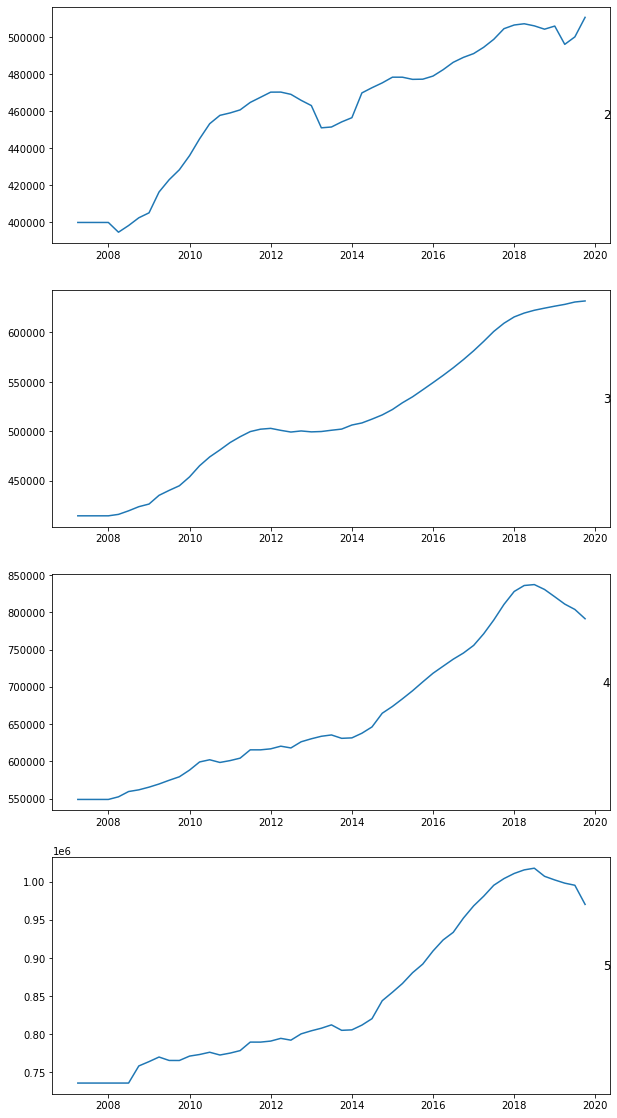

In [11]:
no_cols=len(df.columns)
index=1
plt.figure(figsize=(10,20))
for column in df.columns:
    plt.subplot(no_cols,1,index)
    plt.plot(df[column])
    plt.title(column,loc='right',y=0.5)
    index+=1
plt.show()


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [13]:
df=scaler.fit_transform(df)
print (df)

[[0.04535172 0.         0.         0.        ]
 [0.04535172 0.         0.         0.        ]
 [0.04535172 0.         0.         0.        ]
 [0.04535172 0.         0.         0.        ]
 [0.         0.00669262 0.01219106 0.        ]
 [0.03101333 0.0232459  0.03680209 0.        ]
 [0.06707915 0.04249593 0.04468206 0.07960319]
 [0.09016024 0.05481541 0.05721995 0.09977364]
 [0.18703703 0.09532058 0.07183882 0.12113622]
 [0.24417502 0.11832122 0.08917337 0.10520209]
 [0.29065621 0.13989986 0.10543621 0.10506017]
 [0.35663175 0.1813636  0.13668556 0.12551446]
 [0.434566   0.23306672 0.17441083 0.13287659]
 [0.50489565 0.27408867 0.18471167 0.14341418]
 [0.54384451 0.3066476  0.17213563 0.13054909]
 [0.55507898 0.34117157 0.18080637 0.13941912]
 [0.56929666 0.36815752 0.19215116 0.15102467]
 [0.60404331 0.39202333 0.23084695 0.19060983]
 [0.62782279 0.4031923  0.23080186 0.19056371]
 [0.6518523  0.40705336 0.23548753 0.19535707]
 [0.6521282  0.3978034  0.24786241 0.20801638]
 [0.64164385 

In [14]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(df, test_size=0.10,shuffle=False)


In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator


In [16]:
# define generator
n_input = 5
n_features = 4
generatorTrain = TimeseriesGenerator(train,train,length=n_input,batch_size=1)
generatorTest = TimeseriesGenerator(test,test,length=n_input,batch_size=1)

In [17]:
batch_0=generatorTrain[0]
x,y=batch_0
print(x,y)

[[[0.04535172 0.         0.         0.        ]
  [0.04535172 0.         0.         0.        ]
  [0.04535172 0.         0.         0.        ]
  [0.04535172 0.         0.         0.        ]
  [0.         0.00669262 0.01219106 0.        ]]] [[0.03101333 0.0232459  0.03680209 0.        ]]


In [18]:
train

array([[0.04535172, 0.        , 0.        , 0.        ],
       [0.04535172, 0.        , 0.        , 0.        ],
       [0.04535172, 0.        , 0.        , 0.        ],
       [0.04535172, 0.        , 0.        , 0.        ],
       [0.        , 0.00669262, 0.01219106, 0.        ],
       [0.03101333, 0.0232459 , 0.03680209, 0.        ],
       [0.06707915, 0.04249593, 0.04468206, 0.07960319],
       [0.09016024, 0.05481541, 0.05721995, 0.09977364],
       [0.18703703, 0.09532058, 0.07183882, 0.12113622],
       [0.24417502, 0.11832122, 0.08917337, 0.10520209],
       [0.29065621, 0.13989986, 0.10543621, 0.10506017],
       [0.35663175, 0.1813636 , 0.13668556, 0.12551446],
       [0.434566  , 0.23306672, 0.17441083, 0.13287659],
       [0.50489565, 0.27408867, 0.18471167, 0.14341418],
       [0.54384451, 0.3066476 , 0.17213563, 0.13054909],
       [0.55507898, 0.34117157, 0.18080637, 0.13941912],
       [0.56929666, 0.36815752, 0.19215116, 0.15102467],
       [0.60404331, 0.39202333,

In [19]:
test

array([[0.96037329, 0.95670007, 1.        , 1.        ],
       [0.94487094, 0.96652988, 0.97722023, 0.96225625],
       [0.95938176, 0.97576143, 0.94322052, 0.94525773],
       [0.87429987, 0.984114  , 0.90922081, 0.9304022 ],
       [0.90900342, 0.99511731, 0.88426295, 0.92056357],
       [1.        , 1.        , 0.84098208, 0.83152621]])

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [21]:
EPOCHS=115
#create and fit the LSTM network
#define model

model=Sequential()
model.add(LSTM(50,activation='tanh',input_shape=(n_input,n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam',loss='mse')
model.fit(generatorTrain,epochs=EPOCHS,batch_size=72,shuffle=False)


Epoch 1/115
40/40 [==============================] - 3s 4ms/step - loss: 0.0204
Epoch 2/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0297
Epoch 3/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 4/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 5/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 6/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 7/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 8/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 9/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 10/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 11/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 12/115
40/40 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 13/115
40/40 [=================

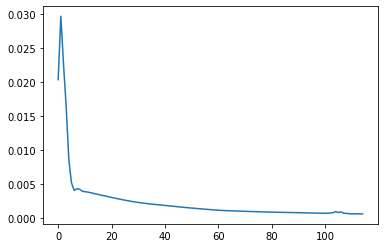

In [22]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [23]:
predictions=[]
first_batch = train[-n_input:]
current_batch = first_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    predictions.append(current_pred) 
    
    #remove first value
    current_batch_rmv_first=current_batch[:,1:,:]
    
    # update the batch 
    current_batch = np.append(current_batch_rmv_first,[[current_pred]],axis=1)

In [24]:
predictions

[array([0.979186  , 0.99076307, 0.9940439 , 1.0472835 ], dtype=float32),
 array([0.9880631, 1.0153564, 1.0229568, 1.0705091], dtype=float32),
 array([0.995533 , 1.0356269, 1.0479532, 1.0864183], dtype=float32),
 array([1.0037903, 1.052936 , 1.069547 , 1.0994849], dtype=float32),
 array([1.0112387, 1.0676112, 1.0881448, 1.1104885], dtype=float32),
 array([1.017197 , 1.0803183, 1.104318 , 1.1198066], dtype=float32)]

In [25]:
true_predictions = scaler.inverse_transform(predictions)

In [26]:
true_predictions

array([[ 508297.94251275,  629867.8304768 ,  835577.69766557,
        1031078.76842976],
       [ 509327.52955216,  635211.92418932,  843914.05619812,
        1037624.84208584],
       [ 510193.90548044,  639616.66204691,  851121.16818976,
        1042108.81686306],
       [ 511151.60331046,  643377.89335103,  857347.22480035,
        1045791.62587357],
       [ 512015.49052681,  646566.8022257 ,  862709.43160915,
        1048892.97232342],
       [ 512706.55052565,  649328.03646879,  867372.59822106,
        1051519.26392841]])

In [27]:
test

array([[0.96037329, 0.95670007, 1.        , 1.        ],
       [0.94487094, 0.96652988, 0.97722023, 0.96225625],
       [0.95938176, 0.97576143, 0.94322052, 0.94525773],
       [0.87429987, 0.984114  , 0.90922081, 0.9304022 ],
       [0.90900342, 0.99511731, 0.88426295, 0.92056357],
       [1.        , 1.        , 0.84098208, 0.83152621]])

In [28]:
true_test=scaler.inverse_transform(test)

In [29]:
true_test

array([[ 506116.,  622466.,  837295., 1017752.],
       [ 504318.,  624602.,  830727., 1007114.],
       [ 506001.,  626608.,  820924., 1002323.],
       [ 496133.,  628423.,  811121.,  998136.],
       [ 500158.,  630814.,  803925.,  995363.],
       [ 510712.,  631875.,  791446.,  970268.]])

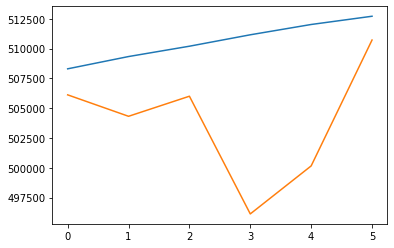

In [30]:
plt.plot(true_predictions[:,0])
plt.plot(true_test[:,0])

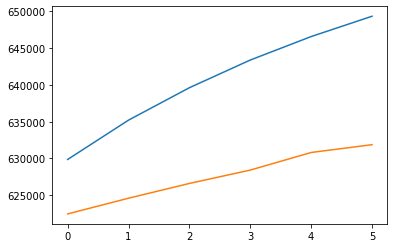

In [31]:
plt.plot(true_predictions[:,1])
plt.plot(true_test[:,1])

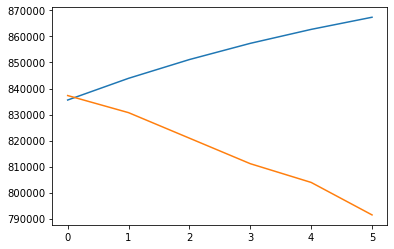

In [32]:
plt.plot(true_predictions[:,2])
plt.plot(true_test[:,2])

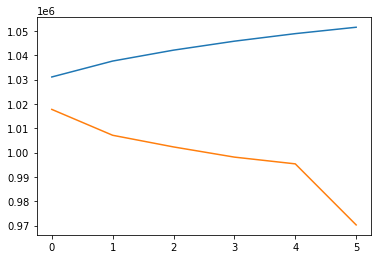

In [33]:
plt.plot(true_predictions[:,3])
plt.plot(true_test[:,3])

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_2=sqrt(mean_squared_error(true_test[:,0],true_predictions[:,0]))
rmse_3=sqrt(mean_squared_error(true_test[:,1],true_predictions[:,1]))
rmse_4=sqrt(mean_squared_error(true_test[:,2],true_predictions[:,2]))
rmse_5=sqrt(mean_squared_error(true_test[:,3],true_predictions[:,3]))

print('2 bedrooms rmse',rmse_2)
print('3 bedrooms rmse',rmse_3)
print('4 bedroom rmse',rmse_4)
print('5 bedroom rmse',rmse_5)

2 bedrooms rmse 8342.396484426923
3 bedrooms rmse 13619.78321563193
4 bedroom rmse 45544.9194413009
5 bedroom rmse 49040.30649941616


In [35]:
#MAPE
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
mape_2=mean_absolute_percentage_error(true_test[:,0],true_predictions[:,0])
mape_3=mean_absolute_percentage_error(true_test[:,1],true_predictions[:,1])
mape_4=mean_absolute_percentage_error(true_test[:,2],true_predictions[:,2])
mape_5=mean_absolute_percentage_error(true_test[:,3],true_predictions[:,3])

print('2 bedrooms',mape_2)
print('3 bedrooms',mape_3)
print('4 bedrooms',mape_4)
print('5 bedroom ',mape_5)

2 bedrooms 1.3402505014498267
3 bedrooms 2.1004831242411317
4 bedrooms 4.679264034583571
5 bedroom  4.472471163245586
